# Build Target Model

Here we work to expand our on target rules to include information about the target site.
We consider three feature classes when building this model:

1. Position within a gene
  1. Guide orientation relative to the direction of transcription
  2. Distance to the end of the CDS
  3. Distance to the start of the CDS
  4. Percent of CDS
2. Protein Domain information:
  1. Whether a guide targets within an annotated protein domain
3. Sequence conservation:
  1. Conservation of 3 nucleotide preceding the cut site
  2. "" succeeding the cut site
  3. Conservation of
4. Amino acid information:
  1. Position independent one-mers
  2. "" two-mers
  3. Position dependent one-mers


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import joblib
import sglearn
import seaborn as sns
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from scipy import stats
import optuna
from joblib import Parallel, delayed
from datetime import datetime
import numpy as np

import target_featurization as ft
from core import (get_predictive_performance,
                  plot_pearson_heatmap,
                  plot_pearson_lollipop,
                  get_tidy_cv_df)
from datasets import dataset_list, get_sg_groups_df


In [2]:

def get_fold_predictions(fold, fold_df, model_name,
                         features = None, base_nt_model = LGBMRegressor(random_state=7, n_jobs=8),
                         aa_seq_df=None, aa_width=8, aa_features=None,
                         protein_domain_df=None,
                         conservation_df=None, cons_small_width=2, cons_large_width=32,
                         base_target_model=Pipeline([('imputer', SimpleImputer(strategy='median')),
                                              ('regressor', LGBMRegressor(random_state=7, n_jobs=8))])):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_target_model: model with a .fit function
    :param features: list
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    # Step 1 - fit nucleotide model
    X_train_seq = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train_seq = train_df['Residual Activity']
    nt_model = clone(base_nt_model)
    nt_model.fit(X_train_seq, y_train_seq)
    test_df = fold_df.query('train == False').reset_index(drop=True)
    X_test_seq = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    test_seq_predictions = nt_model.predict(X_test_seq)
    if features is None:  # only fit the nucleotide model
        test_predictions = test_seq_predictions
    # Step 2 - fit target model
    else:
        (train_target_feature_df,
         train_target_feature_cols) = ft.build_target_feature_df(train_df, features=features,
                                                                 aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                 aa_features=aa_features,
                                                                 protein_domain_df=protein_domain_df,
                                                                 conservation_df=conservation_df,
                                                                 cons_small_width=cons_small_width,
                                                                 cons_large_width=cons_large_width)
        X_train_target = train_target_feature_df[train_target_feature_cols]
        y_train_target = train_df['Residual Activity'] - nt_model.predict(X_train_seq)  # residual from sequence model
        target_model = clone(base_target_model)
        target_model.fit(X_train_target,  y_train_target)
        (test_target_feature_df,
         test_target_feature_cols) = ft.build_target_feature_df(test_df, features=features,
                                                                aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                aa_features=aa_features,
                                                                protein_domain_df=protein_domain_df,
                                                                conservation_df=conservation_df,
                                                                cons_small_width=cons_small_width,
                                                                cons_large_width=cons_large_width)
        X_test_target = test_target_feature_df[test_target_feature_cols]
        test_target_predictions = target_model.predict(X_test_target)
        test_predictions = test_seq_predictions + test_target_predictions
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = test_predictions
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    # return a list of length of one to combine with other training runs
    return dataset_test_predictions


def lgbm_training_iteration(fold_df, train_index,
                            base_nt_model,
                            target_features,
                            aa_seq_df, protein_domain_df,
                            conservation_df,
                            test_index, base_target_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param target_features: list, features to use
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_target_model: LGBMRegressor
    :return: r^2
    """
    # Step 1 - train seq model
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    X_train_val_seq = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train_val_seq = train_df['Residual Activity']
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_val_seq, y_train_val_seq,
                                                                      test_size=0.1, random_state=7)
    nt_model = clone(base_nt_model)
    nt_model.fit(X_train_seq, y_train_seq,
                 early_stopping_rounds=20,
                 eval_set=[(X_val_seq, y_val_seq)],
                 verbose=False)
    # Step 2 - train the target model using the seq model's residuals
    (train_target_feature_df,
     train_target_feature_cols) = ft.build_target_feature_df(train_df,
                                                             features=target_features,
                                                             aa_seq_df=aa_seq_df,
                                                             protein_domain_df=protein_domain_df,
                                                             conservation_df=conservation_df)
    X_train_val_target = train_target_feature_df[train_target_feature_cols]  # train and validation data
    y_train_val_target = train_df['Residual Activity'] - nt_model.predict(X_train_val_seq)  # take residual of nt model
    X_train_target, X_val_target, y_train_target, y_val_target = train_test_split(X_train_val_target,
                                                                                  y_train_val_target,
                                                                                 test_size=0.1, random_state=7)
    target_model = clone(base_target_model)
    target_model.fit(X_train_target, y_train_target,
                     regressor__early_stopping_rounds=20,
                     regressor__eval_set=[(X_val_target, y_val_target)],
                     regressor__verbose=False)
    # test the model
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test_seq = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    (test_target_feature_df,
     test_target_feature_cols) = ft.build_target_feature_df(test_df,
                                                            features=target_features,
                                                            aa_seq_df=aa_seq_df,
                                                            protein_domain_df=protein_domain_df,
                                                            conservation_df=conservation_df)
    X_test_target = test_target_feature_df[test_target_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = nt_model.predict(X_test_seq) + target_model.predict(X_test_target)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df, features, aa_seq_df, protein_domain_df, conservation_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        nt_num_leaves = trial.suggest_int('nt_num_leaves', 8, 256)
        nt_min_child_samples = trial.suggest_int('nt_min_child_samples', 8, 256)
        nt_model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                 num_leaves=nt_num_leaves,
                                 min_child_sample=nt_min_child_samples)
        target_num_leaves = trial.suggest_int('target_num_leaves', 8, 256)
        target_min_child_samples = trial.suggest_int('target_min_child_samples', 8, 256)
        target_model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                 ('regressor',
                                  LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                                num_leaves=target_num_leaves,
                                                min_child_samples=target_min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index,
                                          nt_model,
                                          features,
                                          aa_seq_df, protein_domain_df,
                                          conservation_df,
                                          test_index, target_model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

### Rename Database Columns

In [4]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

## Loading Datasets

In [5]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)


sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)


Context sequences with multiple targets: 0


## Protein Domain Features

In [6]:
domain_model_matrix = ft.get_protein_domain_features(sg_groups_df, protein_domains)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


[]

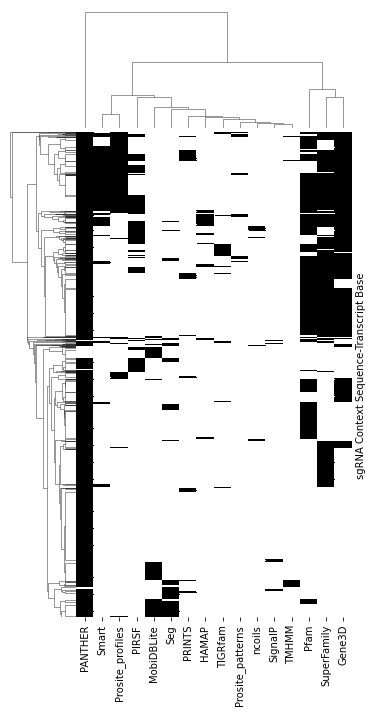

In [7]:
g = sns.clustermap(domain_model_matrix.set_index(['sgRNA Context Sequence', 'Transcript Base']),
                   cmap='binary', cbar_pos=None, metric='hamming')
g.ax_heatmap.get_yaxis().set_ticks([])


In [8]:
long_domain_model_matrix = domain_model_matrix.melt(id_vars=['Transcript Base', 'sgRNA Context Sequence'],
                                                    var_name='source',
                                                    value_name='present')
long_domain_model_matrix = long_domain_model_matrix[long_domain_model_matrix['present'] == 1]
(long_domain_model_matrix[['Transcript Base', 'source']].value_counts()
 .reset_index()['source'].value_counts())

PANTHER             46
Pfam                44
Gene3D              41
SuperFamily         35
Seg                 31
Prosite_patterns    30
MobiDBLite          22
Smart               18
Prosite_profiles    15
PIRSF               11
HAMAP               11
TMHMM                9
SignalP              8
PRINTS               7
TIGRfam              7
ncoils               5
Name: source, dtype: int64

## Conservation of Protein Domains

We'll merge conservation scores with the protein domain matrix to understand how protein domains are conserved

In [9]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))


In [10]:
conservation_aa_i = conservation_df.copy()
conservation_aa_i['aa_i'] = (conservation_aa_i['target position'] - 1) // 3 + 1
conservation_aa_i['loc_id'] = conservation_aa_i['Transcript Base'] + conservation_aa_i['aa_i'].astype(str)
# Filter sifts
conservation_domains = (conservation_aa_i.merge(protein_domains[protein_domains['type'] != 'sifts'],
                                                how='inner',
                                                on='Transcript Base'))
conservation_domains = (conservation_domains[conservation_domains['aa_i']
                        .between(conservation_domains['start'], conservation_domains['end'])])
conservation_non_domains = conservation_aa_i[~conservation_aa_i['loc_id'].isin(conservation_domains['loc_id'])]
conservation_cat = (pd.concat([conservation_domains, conservation_non_domains])
                    .reset_index(drop=True))
conservation_cat['type'] = conservation_cat['type'].fillna('None')
conservation_cat_summary = (conservation_cat.groupby(['type', 'genome'])
                            .agg(median_conservation = ('conservation', 'median'),
                                 n_obs = ('conservation', 'count'))
                            .reset_index()
                            .sort_values('median_conservation'))
conservation_cat_summary['name'] = (conservation_cat_summary['type'] +
                                    '(n=' +
                                    conservation_cat_summary['n_obs'].astype(str) +
                                    ')')
hg_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('hg')]
mm_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('mm')]
hg_conservation_cat = conservation_cat.merge(hg_conservation_cat_summary, how='inner')
hg_conservation_cat['name'] = pd.Categorical(hg_conservation_cat['name'],
                                             categories=hg_conservation_cat_summary['name'])
mm_conservation_cat = conservation_cat.merge(mm_conservation_cat_summary, how='inner')
mm_conservation_cat['name'] = pd.Categorical(mm_conservation_cat['name'],
                                             categories=mm_conservation_cat_summary['name'])

Text(0.5, 1.0, 'Human Training Data\nDomain Conservation')

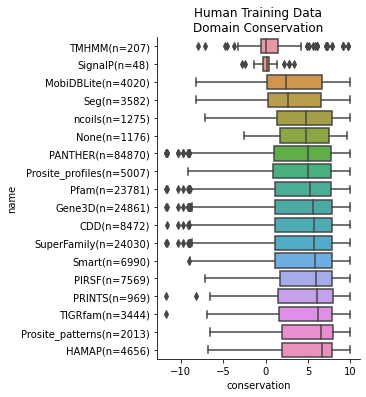

In [11]:
sns.catplot(data=hg_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Human Training Data\nDomain Conservation')

Text(0.5, 1.0, 'Mouse Training Data\nDomain Conservation')

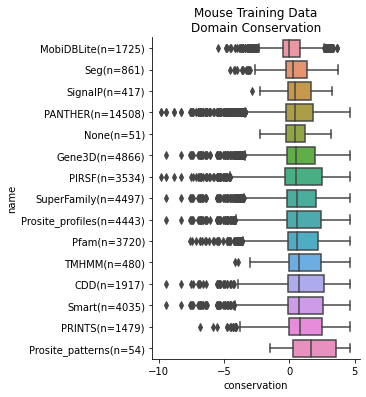

In [12]:
sns.catplot(data=mm_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Mouse Training Data\nDomain Conservation')

## Calculating Residuals

In [13]:
sg_df_residuals = sg_groups_df.copy()
sg_df_residuals['sgRNA Activity'] = (sg_df_residuals.groupby('dataset')
                                     ['sgRNA Activity']
                                     .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7747588150394162, 6.327280047472541e-200)
Doench2014_mouse    (0.7221909327038771, 4.8841724249361805e-189)
Doench2016                        (0.6639725734142461, 3.06e-322)
Wang2014              (0.740204397054155, 4.967999241925921e-178)
dtype: object

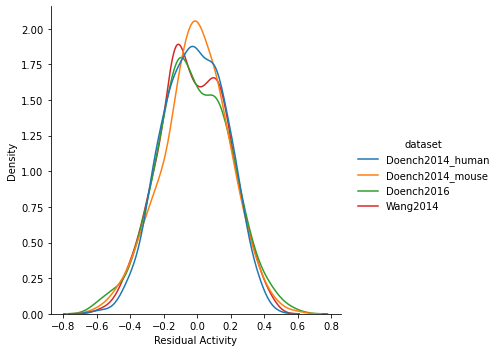

In [14]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']
sns.displot(data=sg_df_residuals, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False)

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [15]:
tidy_cv_df = get_tidy_cv_df(sg_df_residuals, random_state=1)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
19,0,Doench2014_human,1
18,1,Doench2014_human,1
17,2,Doench2014_human,1
16,2,Doench2014_mouse,1
1,0,Doench2014_mouse,2
15,0,Doench2016,2
14,0,Wang2014,2
13,1,Doench2014_mouse,2
12,1,Doench2016,2
11,1,Wang2014,2


- Training sizes vary from 5,258 - 4,253 sgRNAs
- Testing sizes vary from 1,469 - 464 sgRNAs

In [16]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,464
0,0,True,5258
6,1,False,1441
3,1,True,4281
8,2,False,1093
1,2,True,4629
5,3,False,1469
4,3,True,4253
7,4,False,1255
2,4,True,4467


Indeed each gene target (gene) only appears in one set in each fold

In [17]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Testing Feature Sets

### Nucleotide Information Only
Since the endogenous target data appears to have G nucleotide bias, before training any target features,
we'll train a nucleotide sequence only model

In [18]:
nt_only_feature_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions = get_fold_predictions(fold, df, model_name='nt') # features = None
    nt_only_feature_list.append(predictions)

nt_only_predictive_performance, nt_only_agg_performance = get_predictive_performance(nt_only_feature_list,
                                                                                     'Residual Activity')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [19]:
nt_only_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,nt,0.069146,0.079047,0.081376


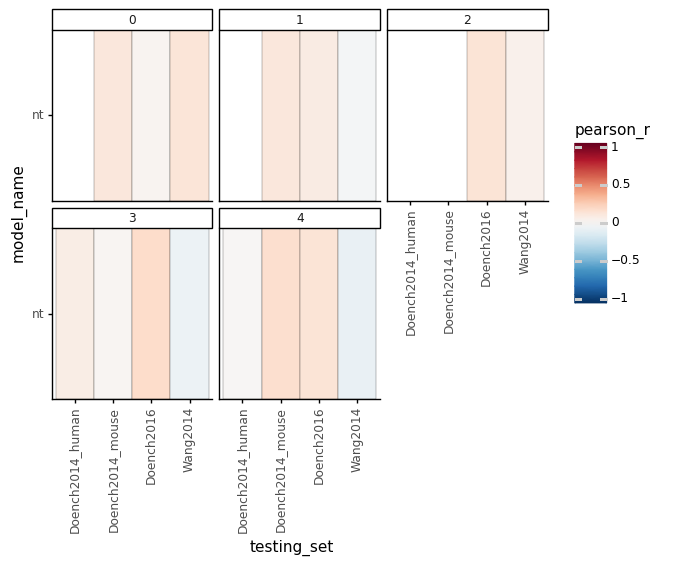

<ggplot: (8763342417116)>

In [20]:
plot_pearson_heatmap(nt_only_predictive_performance)

### Amino Acid Width

In [21]:
aa_width_prediction_list = []
aa_widths = [2, 4, 8, 16, 32]
feature_sets = {'AA core ': ['Pos. Ind. 1mer', 'Hydrophobicity', 'Aromaticity',
                             'Isoelectric Point',
                             'Secondary Structure'],
                'AA expanded ': ['Pos. Ind. 1mer', 'Pos. Ind. 2mer',
                                 'Pos. Dep. 1mer', 'Hydrophobicity', 'Aromaticity',
                                 'Isoelectric Point',
                                 'Secondary Structure']}
for width in aa_widths:
    print(width)
    for aa_name, aa_features in feature_sets.items():
        print(aa_name)
        for fold, df in tidy_cv_df.groupby('cv'):
            print('Fold: ' + str(fold))
            predictions = get_fold_predictions(fold=fold, fold_df=df,
                                               model_name=aa_name + str(width),
                                               features=['aa'],
                                               aa_seq_df=aa_seqs,
                                               protein_domain_df=protein_domains,
                                               conservation_df=conservation_df,
                                               aa_width=width, aa_features=aa_features)
            aa_width_prediction_list.append(predictions)
        print('\n')
    print('\n')

aa_width_predictive_performance, aa_width_agg_performance = get_predictive_performance(aa_width_prediction_list,
                                                                                       'Residual Activity')

2
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




4
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




8
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




16
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




32
AA core 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


AA expanded 
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4






We'll use the core feature set with a width of 8 as our default for Amino Acid featurization

In [22]:
aa_width_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,AA core 16,0.131064,0.151515,0.152397
4,AA core 8,0.123750,0.099023,0.148900
2,AA core 32,0.115531,0.150523,0.127408
5,AA expanded 16,0.113975,0.122185,0.137675
9,AA expanded 8,0.107585,0.102147,0.115927
7,AA expanded 32,0.103226,0.130350,0.112928
3,AA core 4,0.101681,0.080815,0.132159
8,AA expanded 4,0.090916,0.098538,0.099421
1,AA core 2,0.086127,0.083100,0.093764
6,AA expanded 2,0.076218,0.103314,0.072884


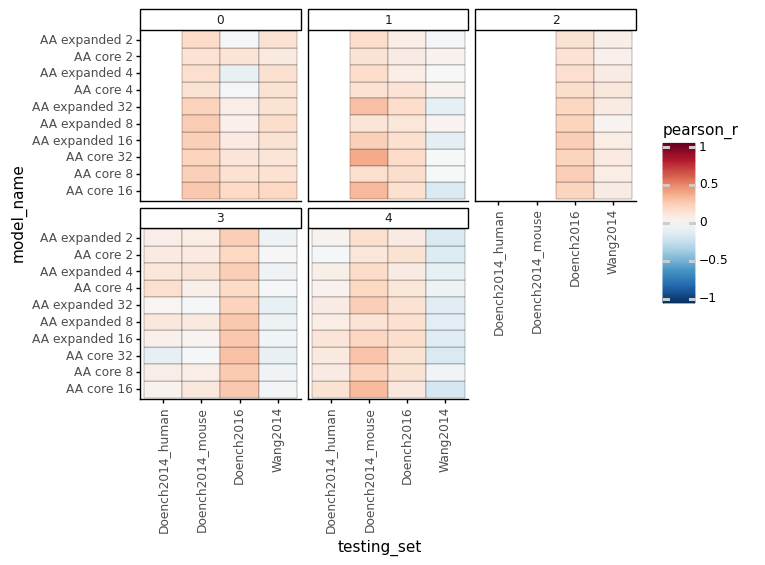

<ggplot: (8763362576818)>

In [23]:
plot_pearson_heatmap(aa_width_predictive_performance)

### Conservation Width

In [24]:
cons_width_prediction_list = []
cons_small_widths = [2, 4, 8]
cons_large_widths = [16, 32, 64]
for small_width in cons_small_widths:
    print('Small: ' + str(small_width))
    for large_width in cons_large_widths:
        print('Large: ' + str(large_width))
        for fold, df in tidy_cv_df.groupby('cv'):
            print('Fold: ' + str(fold))
            predictions = get_fold_predictions(fold, df, model_name='cons ' + str(small_width) +  ', ' +
                                                                    str(large_width),
                                               features=['conservation'],
                                               aa_seq_df=aa_seqs,
                                               protein_domain_df=protein_domains,
                                               conservation_df=conservation_df,
                                               cons_small_width=small_width,
                                               cons_large_width=large_width)
            cons_width_prediction_list.append(predictions)
        print('\n')
    print('\n')

cons_width_predictive_performance, cons_width_agg_performance = get_predictive_performance(cons_width_prediction_list,
                                                                                           'Residual Activity')

Small: 2
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 4
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 8
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4






It looks like a small width of 2 and a large width of 32 is optimal for conservation

In [25]:
cons_width_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
1,"cons 2, 32",0.091989,0.103622,0.096228
7,"cons 8, 32",0.079998,0.114262,0.095072
0,"cons 2, 16",0.079070,0.092784,0.083795
2,"cons 2, 64",0.074233,0.110808,0.070883
8,"cons 8, 64",0.071716,0.114331,0.088997
5,"cons 4, 64",0.071601,0.124038,0.087620
6,"cons 8, 16",0.070256,0.105175,0.105740
4,"cons 4, 32",0.068671,0.108142,0.077696
3,"cons 4, 16",0.066001,0.096488,0.076798


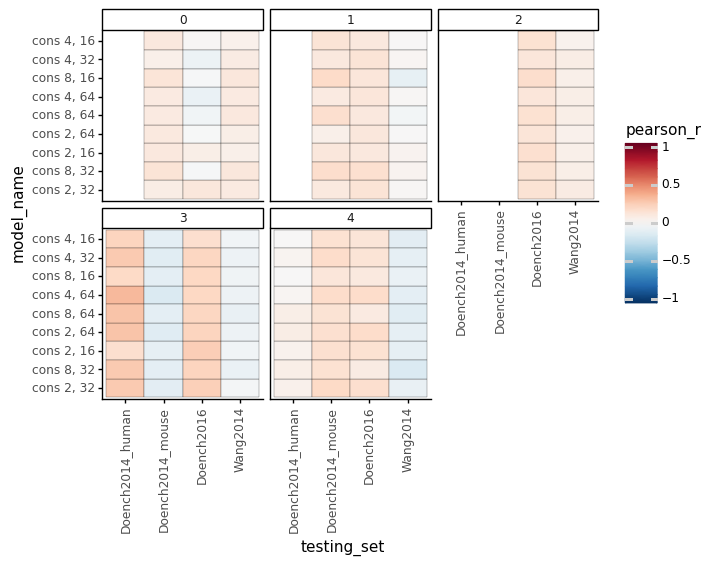

<ggplot: (8763335053716)>

In [26]:
plot_pearson_heatmap(cons_width_predictive_performance)


### Single Feature Sets

In [27]:
single_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name=feature,
                                           features=[feature],
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        single_prediction_list.append(predictions)
    print('\n')

single_predictive_performance, single_agg_performance = get_predictive_performance(single_prediction_list,
                                                                                   'Residual Activity')


position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




All features seem to be learning salient features with the notable exception of positional features in fold 3.
This will be interesting to investigate as domain features are important here.

In [28]:
single_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
2,domain,0.170993,0.174701,0.161008
3,position,0.154201,0.150569,0.157872
0,aa,0.123750,0.099023,0.148900
1,conservation,0.091989,0.103622,0.096228


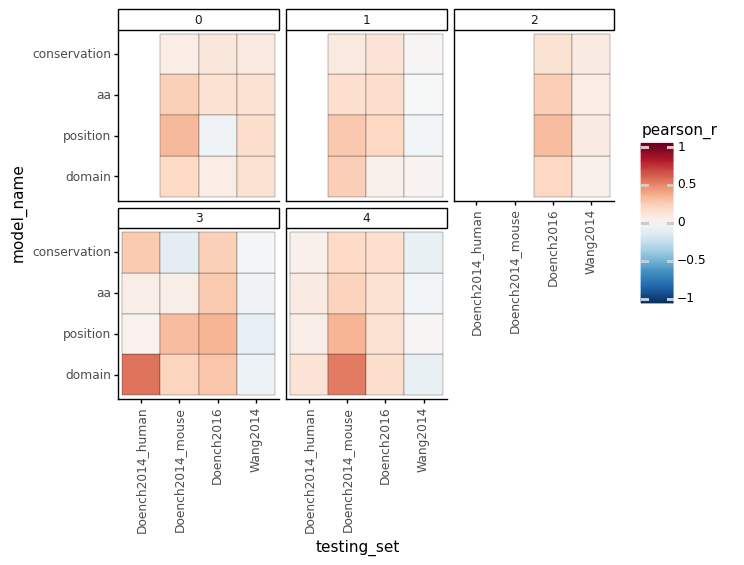

<ggplot: (8763368196666)>

In [29]:
plot_pearson_heatmap(single_predictive_performance)

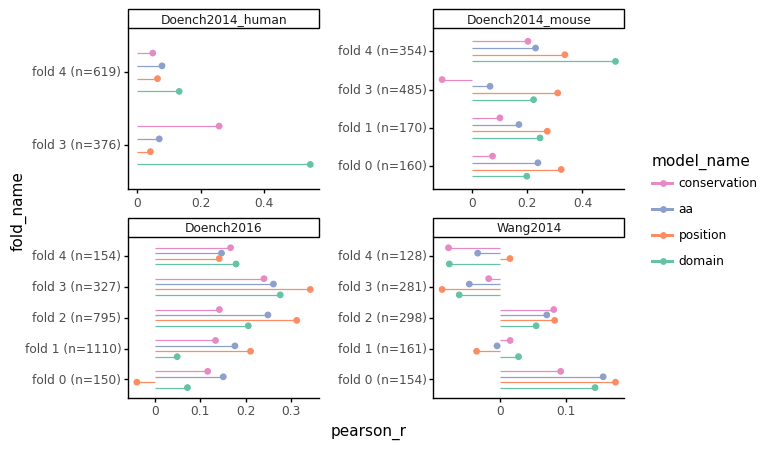

<ggplot: (8763362566587)>

In [30]:
plot_pearson_lollipop(single_predictive_performance)

### Complete Feature Set

In [31]:
complete_feature_list = []
features = ['position', 'aa', 'domain', 'conservation']
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions = get_fold_predictions(fold, df, model_name='All',
                                       features=features,
                                       aa_seq_df=aa_seqs,
                                       protein_domain_df=protein_domains,
                                       conservation_df=conservation_df)
    complete_feature_list.append(predictions)

complete_predictive_performance, complete_agg_performance = get_predictive_performance(complete_feature_list +
                                                                                       single_prediction_list,
                                                                                       'Residual Activity')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [32]:
complete_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,All,0.204945,0.156728,0.180002
3,domain,0.170993,0.174701,0.161008
4,position,0.154201,0.150569,0.157872
1,aa,0.123750,0.099023,0.148900
2,conservation,0.091989,0.103622,0.096228


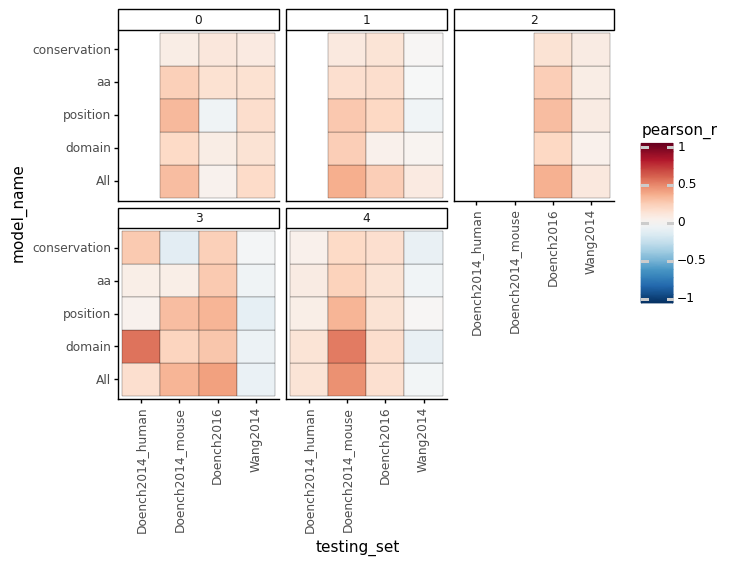

<ggplot: (8763362827978)>

In [33]:
plot_pearson_heatmap(complete_predictive_performance)

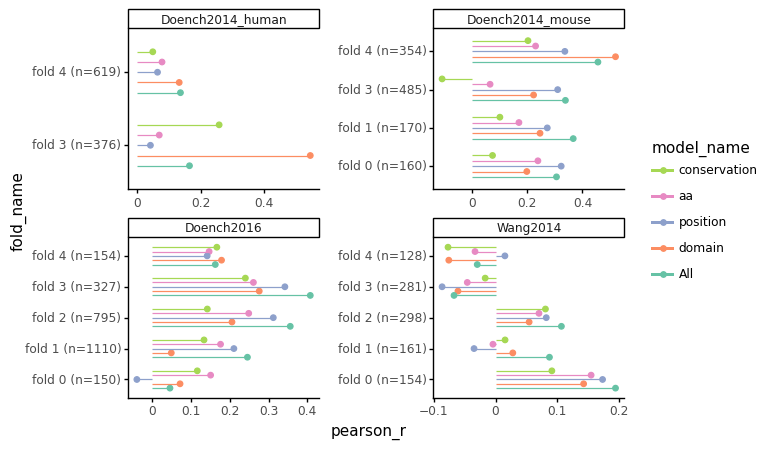

<ggplot: (8763335048840)>

In [34]:
plot_pearson_lollipop(complete_predictive_performance)

### Leave One Set Out


In [35]:
leave_one_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    curr_features = features.copy()
    curr_features.remove(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name='No ' + feature,
                                           features=curr_features,
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        leave_one_prediction_list.append(predictions)
    print('\n')

leave_one_predictive_performance, leave_one_agg_performance = get_predictive_performance(
    leave_one_prediction_list + complete_feature_list, 'Residual Activity')

position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




In [36]:
leave_one_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
2,No conservation,0.214248,0.159428,0.198864
0,All,0.204945,0.156728,0.180002
3,No domain,0.196164,0.151146,0.176694
1,No aa,0.193588,0.172031,0.200491
4,No position,0.174861,0.144677,0.169726


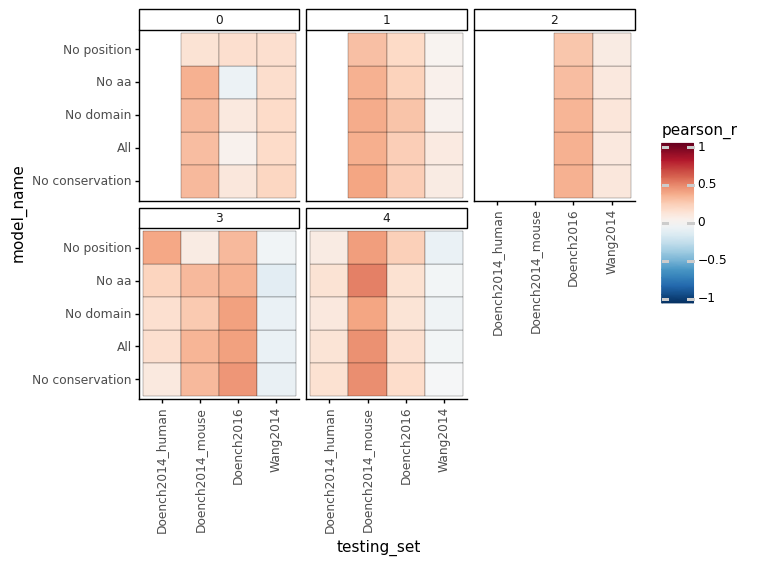

<ggplot: (8763336911192)>

In [37]:
plot_pearson_heatmap(leave_one_predictive_performance)

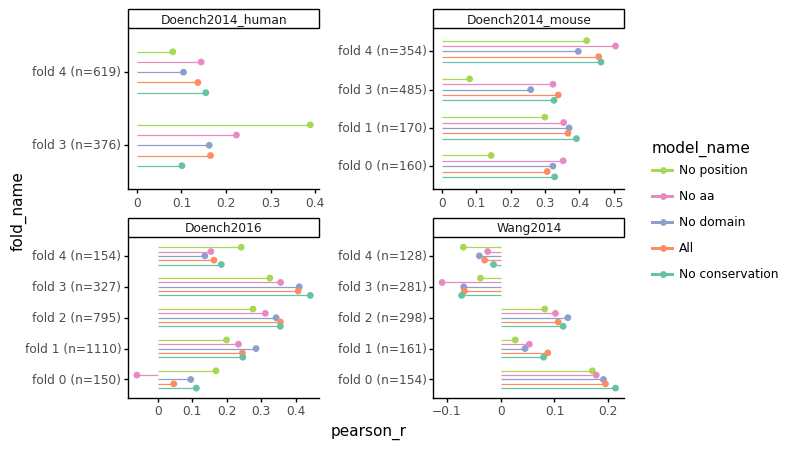

<ggplot: (8763337167246)>

In [38]:
plot_pearson_lollipop(leave_one_predictive_performance)

## Hyperparameter Tuning

We'll use optuna to tune hyperparameters for the model

In [39]:
n_trials = 50
model_name = 'ALL + TPE ' + str(n_trials)

In [40]:
tpe_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_lgbm_objective(fold_train_data, features=features,
                                   aa_seq_df=aa_seqs, protein_domain_df=protein_domains,
                                   conservation_df=conservation_df)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset

    train_df = fold_train_data.copy()
    X_train_val_seq = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train_val_seq = train_df['Residual Activity']
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_val_seq, y_train_val_seq,
                                                                      test_size=0.1, random_state=7)
    nt_model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                             num_leaves=trial.params['nt_num_leaves'],
                             min_child_samples=trial.params['nt_min_child_samples'])
    nt_model.fit(X_train_seq, y_train_seq,
                 early_stopping_rounds=20,
                 eval_set=[(X_val_seq, y_val_seq)],
                 verbose=False)
    # Step 2 - train the target model using the seq model's residuals
    (train_target_feature_df,
     train_target_feature_cols) = ft.build_target_feature_df(train_df,
                                                             features=features,
                                                             aa_seq_df=aa_seqs,
                                                             protein_domain_df=protein_domains,
                                                             conservation_df=conservation_df)
    X_train_val_target = train_target_feature_df[train_target_feature_cols]  # train and validation data
    y_train_val_target = train_df['Residual Activity'] - nt_model.predict(X_train_val_seq)  # take residual of nt model
    X_train_target, X_val_target, y_train_target, y_val_target = train_test_split(X_train_val_target,
                                                                                  y_train_val_target,
                                                                                  test_size=0.1, random_state=7)
    target_model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('regressor', LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01,
                                                         n_estimators=5000,
                                                         num_leaves=trial.params['target_num_leaves'],
                                                         min_child_samples=trial.params['target_min_child_samples']))])
    target_model.fit(X_train_target, y_train_target,
                     regressor__early_stopping_rounds=20,
                     regressor__eval_set=[(X_val_target, y_val_target)],
                     regressor__verbose=False)
    # test the model
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    test_df = fold_test_data
    X_test_seq = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    (test_target_feature_df,
     test_target_feature_cols) = ft.build_target_feature_df(test_df,
                                                            features=features,
                                                            aa_seq_df=aa_seqs,
                                                            protein_domain_df=protein_domains,
                                                            conservation_df=conservation_df)
    X_test_target = test_target_feature_df[test_target_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = nt_model.predict(X_test_seq) + target_model.predict(X_test_target)
    test_predictions['model_name'] = model_name
    test_predictions['fold'] = fold
    tpe_prediction_list.append(test_predictions)


[I 2021-05-14 22:49:36,155] A new study created in memory with name: no-name-f90d7c01-692a-4da8-a0e0-aa09fca23da5
[I 2021-05-14 22:49:45,921] Trial 0 finished with value: 0.09016068494954095 and parameters: {'nt_num_leaves': 27, 'nt_min_child_samples': 202, 'target_num_leaves': 117, 'target_min_child_samples': 188}. Best is trial 0 with value: 0.09016068494954095.
[I 2021-05-14 22:49:53,629] Trial 1 finished with value: 0.061719076698705154 and parameters: {'nt_num_leaves': 251, 'nt_min_child_samples': 142, 'target_num_leaves': 132, 'target_min_child_samples': 25}. Best is trial 0 with value: 0.09016068494954095.
[I 2021-05-14 22:50:01,589] Trial 2 finished with value: 0.08229381071414936 and parameters: {'nt_num_leaves': 74, 'nt_min_child_samples': 132, 'target_num_leaves': 177, 'target_min_child_samples': 208}. Best is trial 0 with value: 0.09016068494954095.
[I 2021-05-14 22:50:09,290] Trial 3 finished with value: 0.08494994950478023 and parameters: {'nt_num_leaves': 102, 'nt_min_ch

Fold: 0
Number of finished trials: 50
Training Time: 0:06:21.420834
Best trial:
  Value: 0.09755806077363013
  Params: 
    nt_num_leaves: 143
    nt_min_child_samples: 227
    target_num_leaves: 114
    target_min_child_samples: 146
Fold: 1
Number of finished trials: 50
Training Time: 0:05:03.199672
Best trial:
  Value: 0.0620269435275661
  Params: 
    nt_num_leaves: 107
    nt_min_child_samples: 103
    target_num_leaves: 31
    target_min_child_samples: 248
Fold: 2
Number of finished trials: 50
Training Time: 0:05:45.647267
Best trial:
  Value: 0.10651499378508551
  Params: 
    nt_num_leaves: 18
    nt_min_child_samples: 160
    target_num_leaves: 8
    target_min_child_samples: 127
Fold: 3
Number of finished trials: 50
Training Time: 0:05:13.406880
Best trial:
  Value: 0.04310207093648895
  Params: 
    nt_num_leaves: 9
    nt_min_child_samples: 169
    target_num_leaves: 42
    target_min_child_samples: 175
Fold: 4
Number of finished trials: 50
Training Time: 0:05:24.153039
Best

In [41]:
tpe_predictive_performance, tpe_agg_performance = get_predictive_performance(
    complete_feature_list + tpe_prediction_list, 'Residual Activity')

In [42]:
tpe_agg_performance

,model_name,mean_pearson,std_pearson,median_pearson
0,ALL + TPE 50,0.267420,0.197927,0.314471
1,All,0.204945,0.156728,0.180002


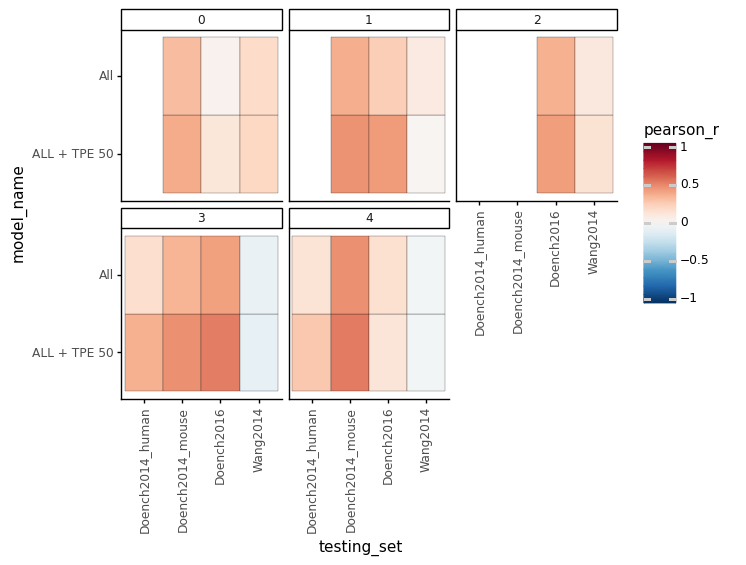

<ggplot: (8763246477322)>

In [43]:
plot_pearson_heatmap(tpe_predictive_performance)

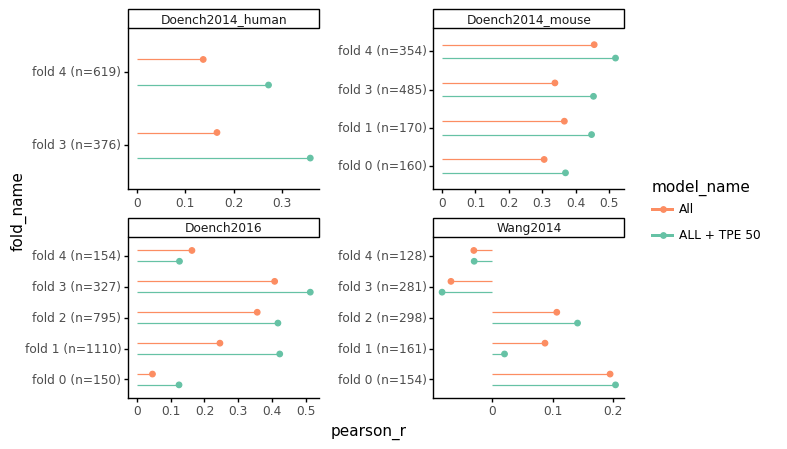

<ggplot: (8763342162776)>

In [44]:
plot_pearson_lollipop(tpe_predictive_performance)